# Import Libraries

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, isnan
from pyspark.sql import Row, Column
from pyspark.sql.functions import lit

import numpy as np

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans

from pyspark.ml.feature import RFormula


from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import col
from pyspark.sql.types import *

import pyspark
from pathlib import Path

import random
import os



from pyspark.sql.functions import when

# Common utility functions

In [4]:
# =============================================================================
# Describing
# =============================================================================

def class_distribution_inspection(df, label = "higgs_bosons"):
    # Extract the label column from the PySpark DataFrame and convert it to a pandas Series
    label_series = df.select(label).toPandas()[label]

    # Plot the distribution of binary labels using pandas plot
    label_counts = label_series.value_counts()
    label_counts.plot(kind='bar', rot=0)

    # Customize the plot
    plt.xlabel('Labels (0 and 1)')
    plt.ylabel('Count')
    plt.title('Distribution of Binary Labels')
    plt.show()

def show(dfs, num_rows = 2):
    for df in dfs:
        df.show(num_rows)

def count(dfs):
    for idx, df in enumerate(dfs):
        print(f"number of rows of df_{idx} : {df.count()}")

def describe(df, single_features = False):
    if single_features:
        for feature_name in df.columns[1:]:
            print("feature: ", feature_name)
            feature_data = df.select(feature_name).toPandas()
            plt.boxplot(feature_data.values)
            plt.show()
            print("\n\n")
            print(feature_data.describe())

    else:
        print("Before normalisation")
        df_pd = df.toPandas()
        df_num = df_pd.iloc[:,1:]
        boxfig = plt.figure()
        plt.boxplot(df_num)
        plt.show()

        print("After normalisation")
        desc_stats = df_num.describe()
        print(desc_stats)
        df_norm = df_num

        print(desc_stats.columns)
        for c in desc_stats.columns:
            mean = desc_stats.loc['mean', c]
            sd = desc_stats.loc['std', c]
            df_norm.loc[:, c] = (df_pd.loc[:, c] - mean) / sd

        df_normarr = df_norm.values
        boxnfig = plt.figure()
        plt.boxplot(df_normarr)
        plt.show()

        corr = df_pd.corr()
        heatfig = plt.figure()
        plt.pcolor(corr)

def f_print(msg):
    msg_len = len(msg)
    to_be_printed = ["="*(msg_len + 6), " "*3 + msg + " "*3,"="*(msg_len + 6)]
    return "\n".join(to_be_printed)


# =============================================================================
# Pre-processing
# =============================================================================

def cast_label_to_integer(df, label = "higgs_bosons"):
    return df.withColumn(label, col(label).cast("integer"))



In [5]:
seed = 42

## Shared sub-workflows

### Getting train-test datasets

#### Train-test split

In [6]:
def train_test_split(df,
                     seed=seed,
                     train_split = 0.7):
    # dataframe train-test splitting
    df_train, df_test = df.randomSplit([train_split, 1 - train_split], seed)
    return df_train, df_test

#### Fit-transform

In [7]:
def fit_transform(df, label = "higgs_bosons_indexes"):
    # rFormula definition
    formula_string = f"{label} ~ ."
    rf = RFormula(formula=formula_string)
    # fitting the dataframe to the rFormula
    rf_fit = rf.fit(df)
    # application of the rFormula
    rf_transfd = rf_fit.transform(df)
    return rf_transfd

#### Normalise

In [8]:
def normalise(df):
    # definition of normaliser
    normaliser = StandardScaler(inputCol="features", outputCol="normFeatures")
    # fitting the dataframe to the normaliser
    normModel = normaliser.fit(df)
    # application of the normalisation
    df_norm = normModel.transform(df)
    # removing the previous column of non-normalised features and replacing it
    # with the new one with normalised features
    df_norm = df_norm.drop("features")
    df_norm = df_norm.withColumnRenamed("normFeatures","features")
    return df_norm

#### Assembly

In [9]:
def assembly(df, inputs, label = "higgs_bosons_indexes"):
    # definition of the vectorAssembler
    vec_assembler = VectorAssembler(inputCols=inputs, outputCol="features")
    # application of the assembler: transform
    df_transfd = vec_assembler.transform(df)
    # selection of the assembled features and label
    df_transfd = df_transfd.select(['features', label])
    return df_transfd

#### Assembly-normalise

In [10]:
def assembly_normalise(df, inputs, label = "higgs_bosons_indexes"):
    # definition of the vectorAssembler
    vec_assembler = VectorAssembler(inputCols=inputs, outputCol="nn_features")
    # definition of the normaliser
    normaliser = StandardScaler(inputCol="nn_features", outputCol="features")
    # definition of two stages
    stages = [vec_assembler, normaliser]
    # definition of the pipeline with two stages: assembler of features and normalisation
    # of the assmbled features
    pipeline = Pipeline(stages = stages)
    # application of the pipeline: fitting and transform
    pipeline_mod = pipeline.fit(df)
    df_transfd = pipeline_mod.transform(df)
    # selection of the assembled features and label
    df_transfd = df_transfd.select(['features', label])
    return df_transfd

#### Get train-test

In [11]:
def get_train_test(df, normalisation, label = "higgs_bosons"):
    # train, test init
    train, test = None, None
    # string label indexer
    stringIndexer = StringIndexer(inputCol=label, outputCol="higgs_bosons_indexes")
    # fitting string-indexer to dataframe
    df_si = stringIndexer.fit(df)
    # to be processed dataframe
    df = df_si.transform(df)
    if normalisation:
        # the normalisation is applied separately for the train and test sets, because it is necessary
        # separate them, due to the fact that the test set is made up of unseen data and it should
        # not be taken into account at training time
        if random.choice([0,1]) == 0:
            # =============================================================================
            # Assembly-normalise
            # =============================================================================
            print("Assembly-normalise")
            # train-test splitting
            print("Train-test splitting")
            train, test = train_test_split(df=df)
            # input columns needed to be assembled and normalised
            inputs = df.columns
            # assembly-normalise train
            print("Assembly-normalise train")
            train = assembly_normalise(train, inputs, label = "higgs_bosons_indexes")
            # assembly-normalise test
            print("Assembly-normalise test")
            test = assembly_normalise(test, inputs, label = "higgs_bosons_indexes")
        else:
            # =============================================================================
            # Fit-transform normalise
            # =============================================================================
            print("Fit-transform normalise")
            # fit-transform of the entire dataset
            print("Fit-transform")
            rf_transfd = fit_transform(df, label = "higgs_bosons_indexes")
            print("Train-test split")
            # tran-test splitting
            train, test = train_test_split(df=rf_transfd)
            # train normalisation
            print("Normalise train")
            train = normalise(train)
            # test normalisation
            print("Normalise test")
            test = normalise(test)
    else:
        if random.choice([0,1]) == 0:
            # =============================================================================
            # Assembly
            # =============================================================================
            print("Assembly")
            # train-test splitting
            print("Train-test splitting")
            train, test = train_test_split(df=df)
            # input columns needed to be assembled and normalised
            print(train)
            print(test)
            inputs = df.columns
            # assembly train
            print("Assembly train")
            train = assembly(train, inputs, label = "higgs_bosons_indexes")
            # assembly test
            print("Assembly test")
            test = assembly(test, inputs, label = "higgs_bosons_indexes")
        else:
            # =============================================================================
            # Fit-transform
            # =============================================================================
            print("Fit-transform")
            # fit transform of the entire dataset
            rf_transfd = fit_transform(df, label = "higgs_bosons_indexes")
            # train-test splitting
            print("Train-test split")
            train, test = train_test_split(df=rf_transfd)

    print("Train schema: ")
    train.printSchema()
    print("Test schema: ")
    test.printSchema()
    return train,test

# Workflows

## Rows with NaNs dropping
This method simply
* unifies the dataframes of the different subjects
* gets rid of the rows containing at least one NaN value
* creates the train-test datasets

In [12]:
def rows_with_NaNs_dropping(df, normalisation
                           ):
    # =============================================================================
    # Rows reduction checking
    # =============================================================================
    class_distribution_inspection(df)
    print(f_print("Rows reduction checking"))
    print("Before dropping rows with NaNs: ")
    print("number of rows: ", df.count())
    df_tbp = df.na.drop("any")
    print("After dropping rows with NaNs: ")
    print("number of rows: ", df_tbp.count())
    class_distribution_inspection(df_tbp)

    # =============================================================================
    # Data description
    # =============================================================================
    print(f_print("Data description"))
    print(df_tbp.columns)
    describe(df = df_tbp, single_features = True)

    # =============================================================================
    # Getting train-test datasets
    # =============================================================================
    print(f_print("Getting train-test datasets"))
    train,test = get_train_test(df_tbp, normalisation)

    return train,test

## Feature selection
This method is used for the selection of the columns that have a variance greater than a certain threshold. If the variance of a column is very low then it will not have a significant role for the discrimination. In this case, the higher the variance, the better the opportunity to discriminate between different classes.
It applies:

* feature selection: features with a variance greater than threshold are selected
* creation of train-test datasets

In [13]:
def axisAggregation_featureSelection(df, normalise, threshold = 0.5, label = "higgs_bosons"):
    print(f_print("Feature aggregation and selection"))
    # =============================================================================
    # Dropping NaNs
    # =============================================================================
    print("Dropping NaNs")
    df_naDropped = df.na.drop("any")

    # =============================================================================
    # Feature selection
    # =============================================================================
    print("Feature selection: features with a variance greater than threshold")
    over_threshold = [col(label)]
    for column in df_naDropped.columns:
        if column != label:
            feature_description = df_naDropped.select(col(column)).toPandas().describe()
            # only the features with a variance greater than a certain threshold
            # are selected
            if feature_description.loc[feature_description.index == 'std'].values[0][0] > threshold:
                over_threshold += [col(column)]
    # selection of the filtered columns
    df_naDropped = df_naDropped.select(over_threshold)
    # this is applied for sake of computational efficiency
    df_naDropped.toPandas().to_csv(Path("temp.csv"))
    df_naDropped = spark.read.format("csv").option("inferSchema", "True").option("header", "True").option("delimiter",",").load("temp.csv")
    df_naDropped = df_naDropped.drop("_c0")

    # =============================================================================
    # Train-test creation
    # =============================================================================
    print("Train-test creation")
    train,test = get_train_test(df_naDropped, normalise)
    return train,test

## Dropping columns


In [68]:
def dropping_columns_from_df(df, normalise, columns_to_drop):
    print(f_print("Dropping kineamtic properites columns"))
    # =============================================================================
    # Dropping kinematic properties columns
    # =============================================================================
    print("Dropping heart_rate column")
    df_drop = df.drop(*columns_to_drop)
 
    # =============================================================================
    # Train-test computation
    # =============================================================================
    train, test = get_train_test(df_drop, normalise)
    return train, test

## Values prediction
This method tries to avoid loosing too many rows by predicting the missing values with:
* nearest neighbour
* linear interpolation

### Values predictors
These functions are used to predict the missing values in different ways.
* **Nearest neighbour**: looks at the nearest non-NaN value
* **Linear interpolation**: fitting and interpolating a line between the nearest left and right non NaN values

In [20]:
def nn(left_bound, right_bound, nan_idx):
    # bounds of the first left non NaN values and the first right one
    bounds = np.array([left_bound, right_bound])
    # for each NaN value the distance between its position and the position of the left bound is computed
    left_distance = np.abs(nan_idx - left_bound)
    # for each NaN value the distance between its position and the position of the right bound is computed
    right_distance = np.abs(right_bound - nan_idx)
    # distances formalisation
    distances = np.array([left_distance, right_distance])
    # computation of the nearest neighbour
    nearest_idx = bounds[np.argmin(distances)]
    return nearest_idx

def li(left_bound, right_bound, nan_idx, values):
    # computation of the number of steps between
    steps = right_bound - left_bound
    # distance between the current nan_idx and the left bound
    current = nan_idx - left_bound
    # the slope of the interpolating line
    slope = (values[right_bound] - values[left_bound])/steps
    # prediction computation
    prediction = float(slope*current + left_bound)
    return prediction

In [21]:
def replace_nans(dfs, feature, method):
    for i in range(len(dfs)):
        df = dfs[i]
        # values extraction from the column of interest
        values = [row[feature] for row in df.select(feature).collect()]
        # boolean mask for nan values
        nan_mask = np.array(np.isnan(values), dtype = int)
        # computation of the NaN values positions
        nan_indexes = np.nonzero(nan_mask)[0]
        # computation of the non NaN values positions
        non_nan_indexes = np.array(sorted(list(set(range(len(values))) - set(nan_indexes))))

        # moving by non_nan_indexes bounds
        # the j counter is pointing onto the position of the left bound
        j = 0
        # fixing the first left non_nan_bound
        left_bound = non_nan_indexes[j]
        # fixing the first right non_nan_bound
        right_bound = non_nan_indexes[j + 1]

        # moving the left bound
        j += 1
        # bounds definition
        bounds = np.array([left_bound, right_bound])

        # for each nan_idx
        for nan_idx in nan_indexes:
            if j == len(non_nan_indexes)-1:
                # the left bound is set equal to the right one
                left_bound = right_bound
            # otherwise if the left non_nan_idx is the last but one
            elif j < len(non_nan_indexes)-1:
                # and the nan idx is next to the right bound
                if nan_idx > right_bound:
                    # the left bound is set to the right one
                    left_bound = right_bound
                    # and the right bound is set to the last non_nan value
                    right_bound = non_nan_indexes[j + 1]
                    j += 1

                if method == 'nn':
                    idx = nn(left_bound, right_bound, nan_idx)
                    values[nan_idx] = values[idx]
                elif method == 'li':
                    value = li(left_bound, right_bound, nan_idx, values)
                    values[nan_idx] = value

        # column values update
        values_schema = StructType([StructField(feature,DoubleType(),False)])
        values_data = [Row(value)  for value in values]
        df_values = spark.createDataFrame(values_data, values_schema)
        df_values = df_values.select("*").withColumn("index", monotonically_increasing_id())

        df = df.select("*").withColumn("index", monotonically_increasing_id())
        df = df.drop(feature)
        df = df.join(df_values, df.index == df_values.index)
        df = df.drop('index')
        dfs[i] = df
    return dfs

## Training

In [22]:
def trainer(classifiers, train, label):
    train_results = {}

    for c in classifiers:
        if not isinstance(c, KMeans):
            c.setLabelCol(label)
        print(c.explainParams())
        # fitting the model to the data
        c_fitted = c.fit(train)
        # learning patterns from the data
        train_result = c_fitted.transform(train).select(label,col("prediction").cast('double'))
        print(train_result)
        # training results
        train_results[c] = {'cls' : c_fitted,
                            'train_result' : train_result}

        # metric evaluation
        for metric in ['accuracy','f1']:
            evaluator = MulticlassClassificationEvaluator(
                labelCol=label, predictionCol="prediction", metricName=metric)
            train_results[c][metric] = evaluator.evaluate(train_result)

    return train_results

In [23]:
def training(train, label = "higgs_bosons_indexes"):
    num_labels = len(np.unique([row[label] for row in train.select(label).collect()]))
    print(f_print("Training"))
    # classifiers definition
    train_results = trainer([DecisionTreeClassifier(seed = seed),
                             RandomForestClassifier(seed = seed),
                             KMeans().setK(num_labels).setSeed(seed)
                           ], train, label)
    print(f_print("Train results"))
    print(train_results)
    return train_results

## Testing

In [24]:
def tester(classifiers, test, label):
    test_results = {}

    for classifier in classifiers:
        print(classifiers[classifier])
        print(type(classifiers[classifier]))
        cls = classifiers[classifier]['cls']
        print("Classifier: ", classifier)
        # testing the classifier on the test set
        test_result = cls.transform(test).select(label,col("prediction").cast('double'))
        test_result.show()
        # test results
        test_results[classifier] = {'cls' : cls,
                                    'test_result' : test_result}

        # metric evaluation
        for metric in ['accuracy','f1']:
            evaluator = MulticlassClassificationEvaluator(
              labelCol=label, predictionCol="prediction", metricName=metric)
            test_results[classifier][metric] = evaluator.evaluate(test_result)

    return test_results

In [25]:
def testing(test, train_results, label = "higgs_bosons_indexes"):
    print(f_print("Testing"))
    # testing the trained model on the test set
    test_results = tester(train_results, test, label)
    print(f_print("Test results"))
    print(test_results)

# Session creation

In [26]:
spark = SparkSession.builder.appName("freeproj").master("yarn").getOrCreate() # from node-master

In [27]:
spark = SparkSession.builder.appName("freeproj").master("spark://node-master:7777").getOrCreate() # from node-user

# Schema definition

## Data schema definition

In [62]:
class_label_column = ["higgs_bosons"]
kinematic_properties_columns = [f"lepton{tag}" for tag in [ "_pT", "_eta", "_phi"]] +\
    ["missing_energy_magnitude", "missing_energy_phi"] +\
    [f"jet{number}{tag}" for number in ["_1", "_2", "_3", "_4"] for tag in ["_pt", "_eta", "_phi", "_b-tag"]]
functions_columns = [f"m{tag}" for tag in ["_jj", "_jjj", "_lv", "_jlv", "_bb", "_wbb", "_wwbb"]]

data_schema_names = class_label_column + kinematic_properties_columns + functions_columns
data_schema_names

['higgs_bosons',
 'lepton_pT',
 'lepton_eta',
 'lepton_phi',
 'missing_energy_magnitude',
 'missing_energy_phi',
 'jet_1_pt',
 'jet_1_eta',
 'jet_1_phi',
 'jet_1_b-tag',
 'jet_2_pt',
 'jet_2_eta',
 'jet_2_phi',
 'jet_2_b-tag',
 'jet_3_pt',
 'jet_3_eta',
 'jet_3_phi',
 'jet_3_b-tag',
 'jet_4_pt',
 'jet_4_eta',
 'jet_4_phi',
 'jet_4_b-tag',
 'm_jj',
 'm_jjj',
 'm_lv',
 'm_jlv',
 'm_bb',
 'm_wbb',
 'm_wwbb']

In [29]:
data_schema_types = [FloatType()] + [DoubleType()]*28
data_schema_types

[FloatType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType(),
 DoubleType()]

In [30]:
data_schema = StructType([StructField(f_name, f_type) for f_name, f_type in zip(data_schema_names, data_schema_types)])
data_schema

StructType([StructField('higgs_bosons', FloatType(), True), StructField('lepton_pT', DoubleType(), True), StructField('lepton_eta', DoubleType(), True), StructField('lepton_phi', DoubleType(), True), StructField('missing_energy_magnitude', DoubleType(), True), StructField('missing_energy_phi', DoubleType(), True), StructField('jet_1_pt', DoubleType(), True), StructField('jet_1_eta', DoubleType(), True), StructField('jet_1_phi', DoubleType(), True), StructField('jet_1_b-tag', DoubleType(), True), StructField('jet_2_pt', DoubleType(), True), StructField('jet_2_eta', DoubleType(), True), StructField('jet_2_phi', DoubleType(), True), StructField('jet_2_b-tag', DoubleType(), True), StructField('jet_3_pt', DoubleType(), True), StructField('jet_3_eta', DoubleType(), True), StructField('jet_3_phi', DoubleType(), True), StructField('jet_3_b-tag', DoubleType(), True), StructField('jet_4_pt', DoubleType(), True), StructField('jet_4_eta', DoubleType(), True), StructField('jet_4_phi', DoubleType(),

# Data loading

In [33]:
df = spark.read.format("csv").schema(data_schema).option("header", "False").option("inferSchema", "True").option("delimiter",",").load(f"hdfs://node-master:9000/Unibo/magistrale/bda/Dataset/HIGGS.csv")

In [34]:
df.show(10)

+------------+------------------+-------------------+--------------------+------------------------+--------------------+------------------+--------------------+--------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+--------------------+-------------------+-----------------+-------------------+--------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|higgs_bosons|         lepton_pT|         lepton_eta|          lepton_phi|missing_energy_magnitude|  missing_energy_phi|          jet_1_pt|           jet_1_eta|           jet_1_phi|       jet_1_b-tag|          jet_2_pt|          jet_2_eta|           jet_2_phi|       jet_2_b-tag|          jet_3_pt|           jet_3_eta|          jet_3_phi|      jet_3_b-tag|           jet_4_pt|           jet_4_eta|           jet_4_phi|      jet

In [35]:
df.dtypes

[('higgs_bosons', 'float'),
 ('lepton_pT', 'double'),
 ('lepton_eta', 'double'),
 ('lepton_phi', 'double'),
 ('missing_energy_magnitude', 'double'),
 ('missing_energy_phi', 'double'),
 ('jet_1_pt', 'double'),
 ('jet_1_eta', 'double'),
 ('jet_1_phi', 'double'),
 ('jet_1_b-tag', 'double'),
 ('jet_2_pt', 'double'),
 ('jet_2_eta', 'double'),
 ('jet_2_phi', 'double'),
 ('jet_2_b-tag', 'double'),
 ('jet_3_pt', 'double'),
 ('jet_3_eta', 'double'),
 ('jet_3_phi', 'double'),
 ('jet_3_b-tag', 'double'),
 ('jet_4_pt', 'double'),
 ('jet_4_eta', 'double'),
 ('jet_4_phi', 'double'),
 ('jet_4_b-tag', 'double'),
 ('m_jj', 'double'),
 ('m_jjj', 'double'),
 ('m_lv', 'double'),
 ('m_jlv', 'double'),
 ('m_bb', 'double'),
 ('m_wbb', 'double'),
 ('m_wwbb', 'double')]

# Raw Data

## General pre-processing

### Cast the Float label class to Integer

In [36]:
df_cast = cast_label_to_integer(df)
df_cast.show(10)

+------------+------------------+-------------------+--------------------+------------------------+--------------------+------------------+--------------------+--------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+--------------------+-------------------+-----------------+-------------------+--------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|higgs_bosons|         lepton_pT|         lepton_eta|          lepton_phi|missing_energy_magnitude|  missing_energy_phi|          jet_1_pt|           jet_1_eta|           jet_1_phi|       jet_1_b-tag|          jet_2_pt|          jet_2_eta|           jet_2_phi|       jet_2_b-tag|          jet_3_pt|           jet_3_eta|          jet_3_phi|      jet_3_b-tag|           jet_4_pt|           jet_4_eta|           jet_4_phi|      jet

### Limtit the dataset

In [37]:
df_lim = df_cast.limit(100000)

### Class distribution analysis

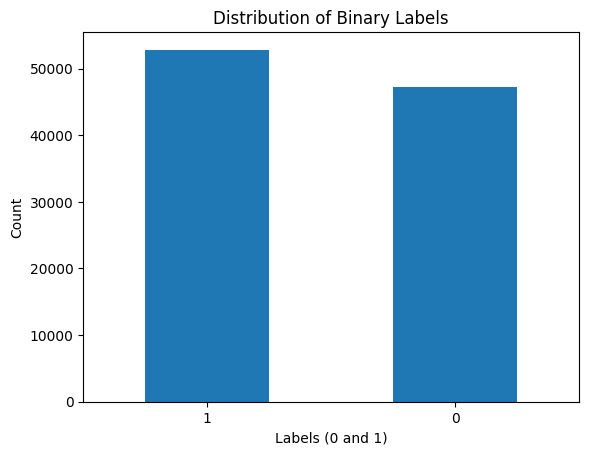

In [38]:
class_distribution_inspection(df_lim)

## NaNs handling

### Features with NaNs

In [41]:

num_nans = [df_lim.select(feature).filter(
    isnan(col(feature)) |
    col(feature).isNull() | 
    (col(feature) == "")
    ).count() for feature in df_lim.columns]
num_nans


'\nnum_nans = [df_lim.select(feature).filter(\n    isnan(col(feature)) |\n    col(feature).isNull() | \n    (col(feature) == "")\n    ).count() for feature in df_lim.columns]\nnum_nans\n'

The features columns are already free of Nan values!

*If* There where Nan values ther would be several options:
* Getting rid of the columns with a very high number of NaNs, like the _heart-rate_ one. But it might contain useful information for the task.
* Getting rid of the rows where there are the NaNs. Since there are many rows with NaN heart values, it is a bad idea of eliminating them because they are useful data for the training
* Filling NaN values with predictions based on Nearest Neighbour or Linear Interpolation technigues.

### Rows with NaNs dropping

#### Normalised

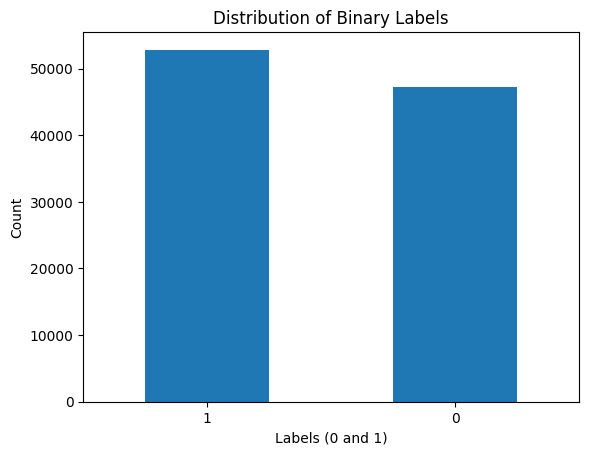

   Rows reduction checking   
Before dropping rows with NaNs: 
number of rows:  100000
After dropping rows with NaNs: 
number of rows:  100000


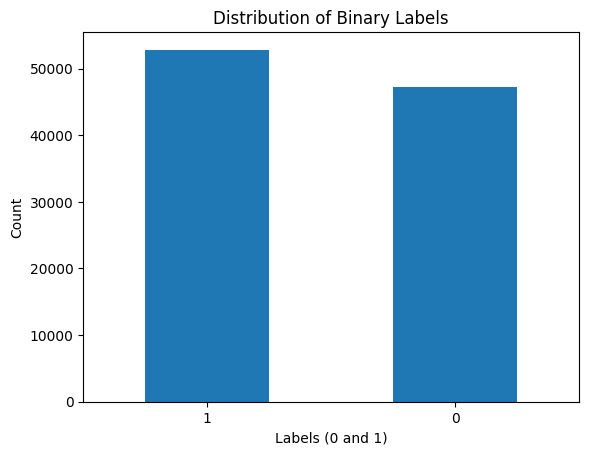

   Data description   
['higgs_bosons', 'lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b-tag', 'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b-tag', 'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b-tag', 'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
feature:  lepton_pT


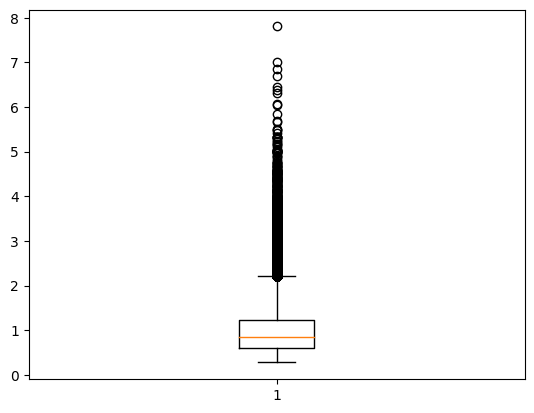




           lepton_pT
count  100000.000000
mean        0.990371
std         0.561837
min         0.274697
25%         0.590936
50%         0.854835
75%         1.236776
max         7.805887
feature:  lepton_eta


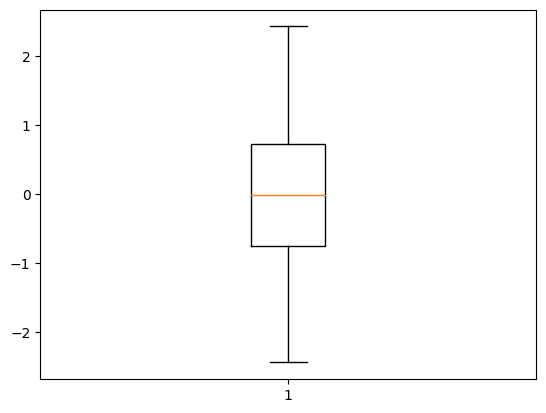




          lepton_eta
count  100000.000000
mean       -0.003816
std         1.004841
min        -2.434976
25%        -0.741244
50%        -0.002976
75%         0.735292
max         2.433894
feature:  lepton_phi


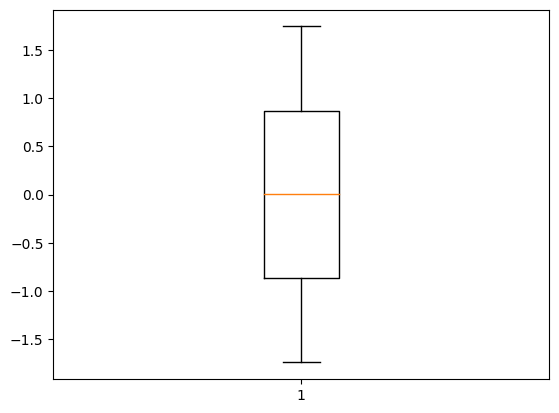




          lepton_phi
count  100000.000000
mean       -0.001638
std         1.006189
min        -1.742508
25%        -0.868047
50%         0.000971
75%         0.868220
max         1.743236
feature:  missing_energy_magnitude


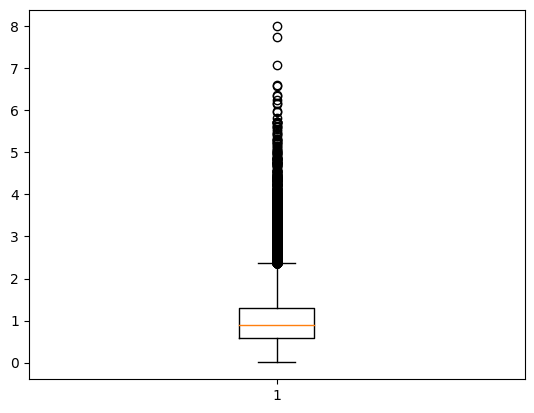




       missing_energy_magnitude
count             100000.000000
mean                   0.995049
std                    0.595360
min                    0.001283
25%                    0.575635
50%                    0.890268
75%                    1.290871
max                    7.998711
feature:  missing_energy_phi


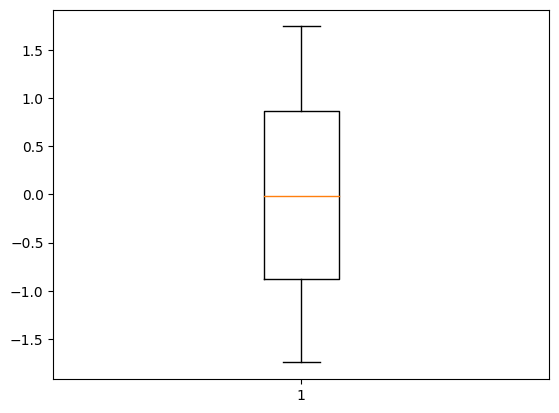




       missing_energy_phi
count       100000.000000
mean            -0.007613
std              1.006997
min             -1.743944
25%             -0.881465
50%             -0.011024
75%              0.865868
max              1.743229
feature:  jet_1_pt


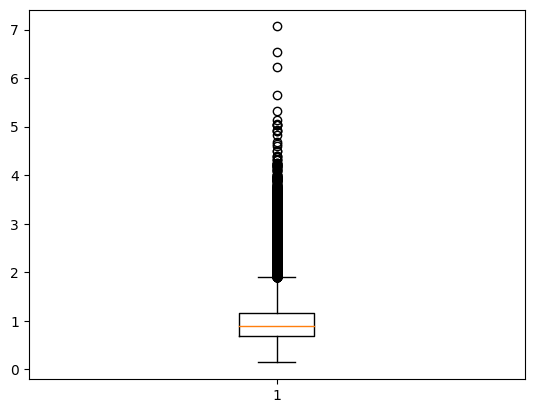




            jet_1_pt
count  100000.000000
mean        0.987114
std         0.473118
min         0.139976
25%         0.676336
50%         0.892163
75%         1.167809
max         7.064657
feature:  jet_1_eta


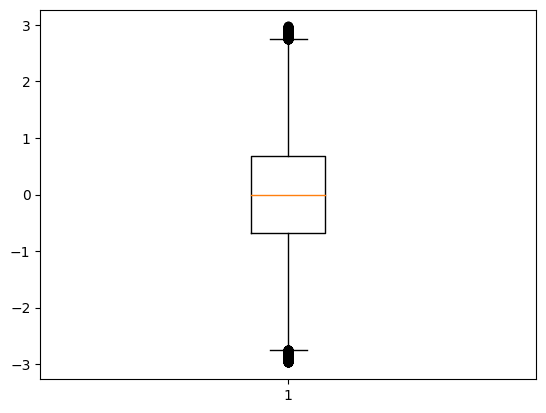




           jet_1_eta
count  100000.000000
mean       -0.003000
std         1.008685
min        -2.968735
25%        -0.688235
50%        -0.000025
75%         0.683233
max         2.969674
feature:  jet_1_phi


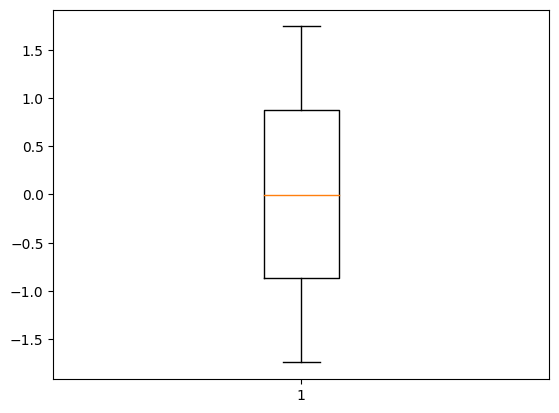




           jet_1_phi
count  100000.000000
mean        0.000438
std         1.008430
min        -1.741237
25%        -0.867542
50%        -0.003822
75%         0.871223
max         1.741454
feature:  jet_1_b-tag


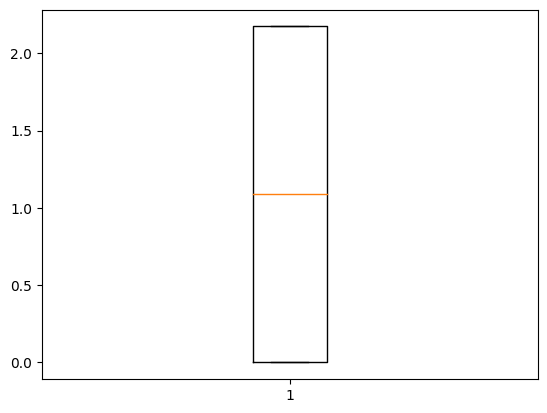




         jet_1_b-tag
count  100000.000000
mean        0.998344
std         1.027402
min         0.000000
25%         0.000000
50%         1.086538
75%         2.173076
max         2.173076
feature:  jet_2_pt


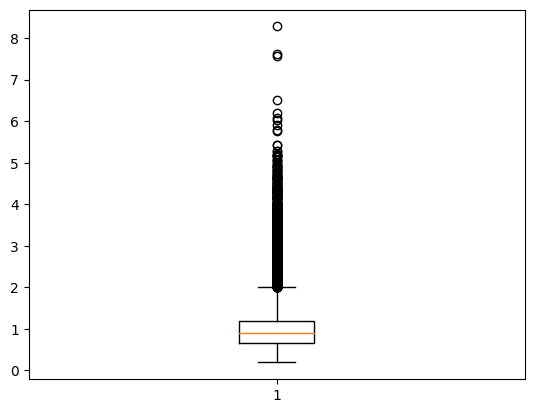




            jet_2_pt
count  100000.000000
mean        0.991302
std         0.498242
min         0.188981
25%         0.656964
50%         0.889256
75%         1.199483
max         8.280169
feature:  jet_2_eta


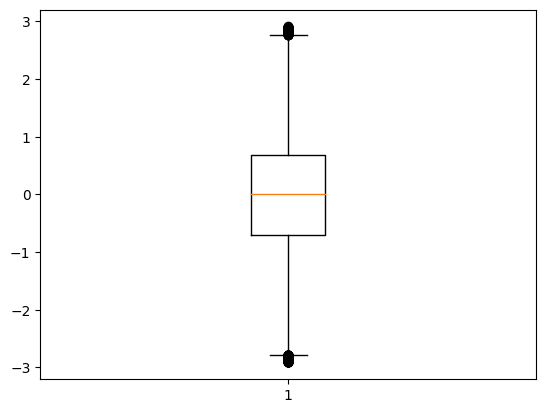




           jet_2_eta
count  100000.000000
mean       -0.001061
std         1.004953
min        -2.913090
25%        -0.695443
50%         0.002003
75%         0.691921
max         2.913210
feature:  jet_2_phi


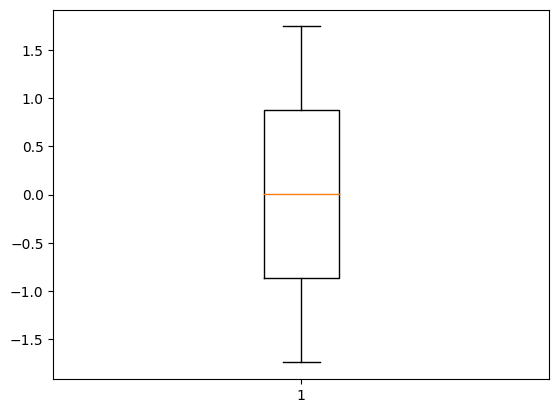




           jet_2_phi
count  100000.000000
mean        0.003546
std         1.006867
min        -1.742372
25%        -0.868515
50%         0.008222
75%         0.876531
max         1.743175
feature:  jet_2_b-tag


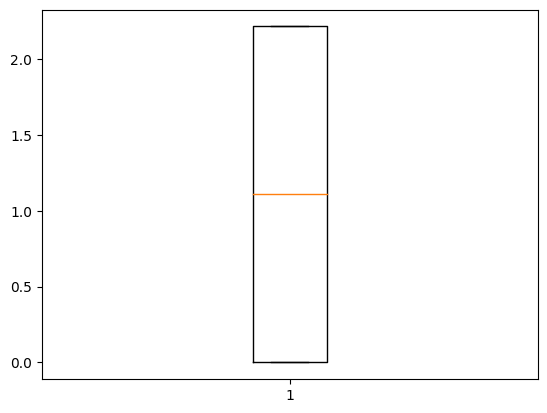




         jet_2_b-tag
count  100000.000000
mean        1.004145
std         1.049192
min         0.000000
25%         0.000000
50%         1.107436
75%         2.214872
max         2.214872
feature:  jet_3_pt


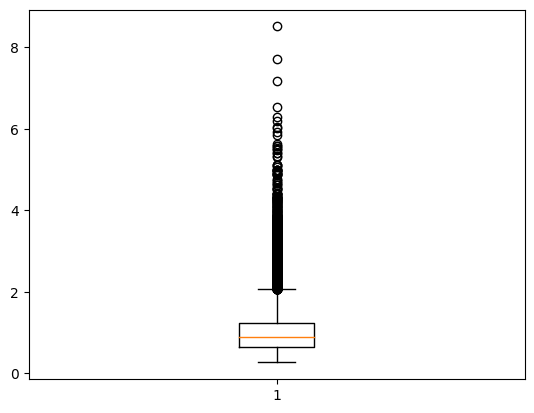




            jet_3_pt
count  100000.000000
mean        0.993414
std         0.487705
min         0.263608
25%         0.654892
50%         0.898479
75%         1.221798
max         8.509908
feature:  jet_3_eta


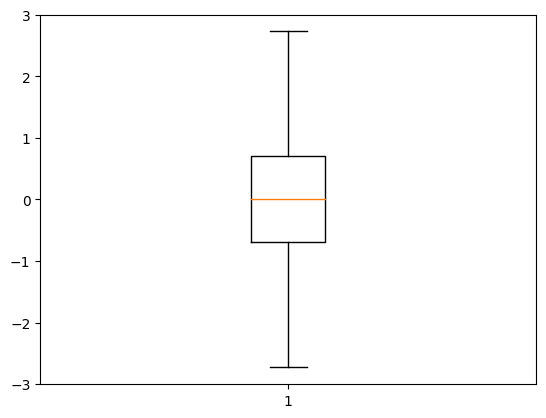




           jet_3_eta
count  100000.000000
mean        0.002149
std         1.008668
min        -2.729663
25%        -0.696167
50%         0.001993
75%         0.701975
max         2.730009
feature:  jet_3_phi


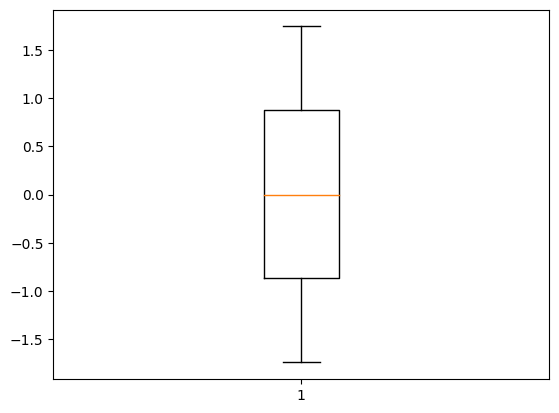




           jet_3_phi
count  100000.000000
mean        0.001222
std         1.005330
min        -1.742069
25%        -0.865587
50%        -0.000752
75%         0.873614
max         1.742884
feature:  jet_3_b-tag


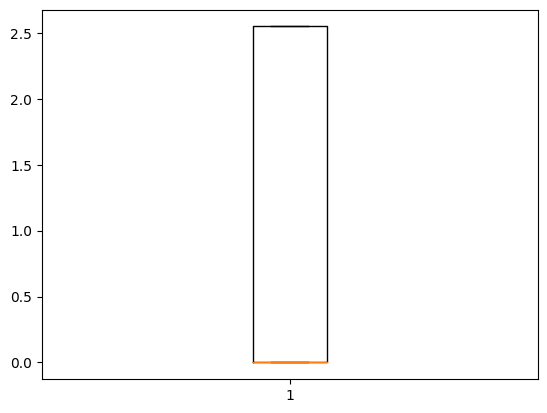




         jet_3_b-tag
count  100000.000000
mean        1.005580
std         1.196112
min         0.000000
25%         0.000000
50%         0.000000
75%         2.548224
max         2.548224
feature:  jet_4_pt


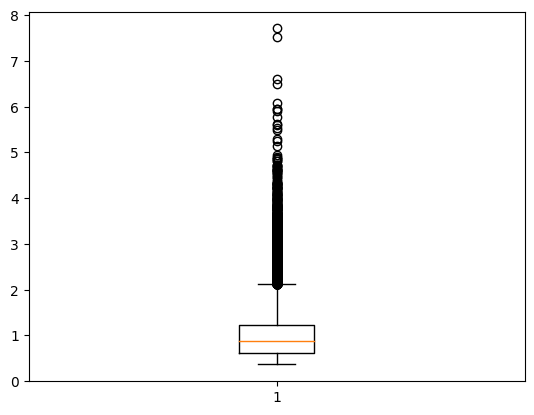




            jet_4_pt
count  100000.000000
mean        0.985523
std         0.504635
min         0.365354
25%         0.617463
50%         0.869207
75%         1.220687
max         7.705783
feature:  jet_4_eta


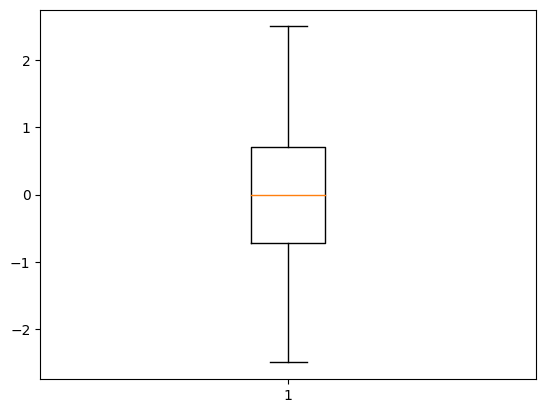




           jet_4_eta
count  100000.000000
mean       -0.007575
std         1.009173
min        -2.497265
25%        -0.725017
50%        -0.010455
75%         0.710770
max         2.498009
feature:  jet_4_phi


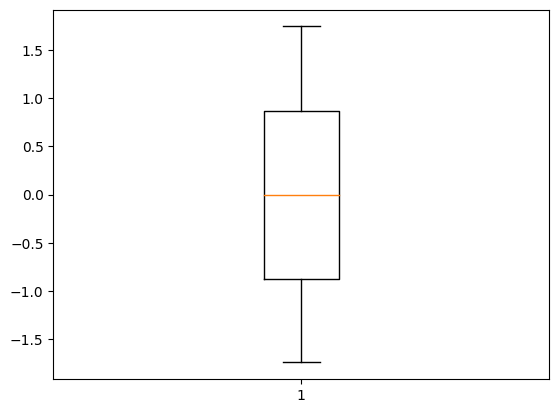




           jet_4_phi
count  100000.000000
mean       -0.004029
std         1.007090
min        -1.742691
25%        -0.877028
50%        -0.009698
75%         0.869386
max         1.743372
feature:  jet_4_b-tag


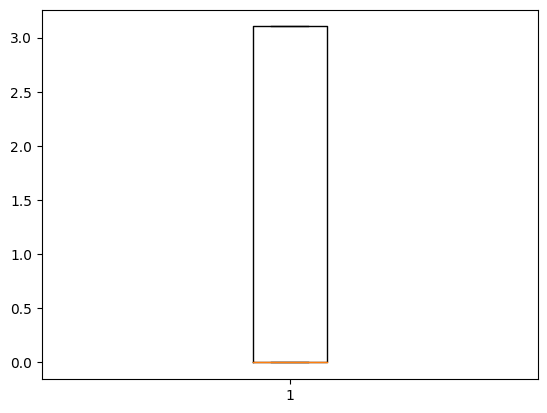




         jet_4_b-tag
count  100000.000000
mean        0.992721
std         1.396788
min         0.000000
25%         0.000000
50%         0.000000
75%         3.101961
max         3.101961
feature:  m_jj


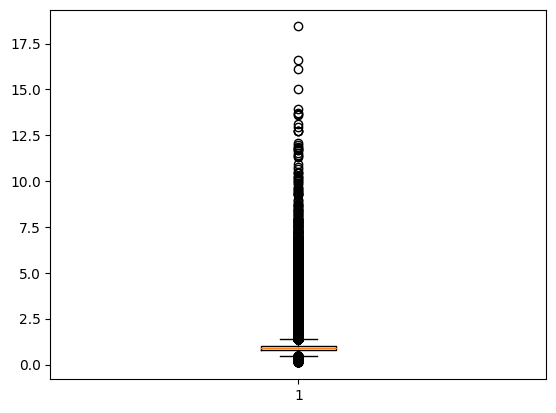




                m_jj
count  100000.000000
mean        1.032611
std         0.652455
min         0.110875
25%         0.791306
50%         0.895600
75%         1.025925
max        18.428827
feature:  m_jjj


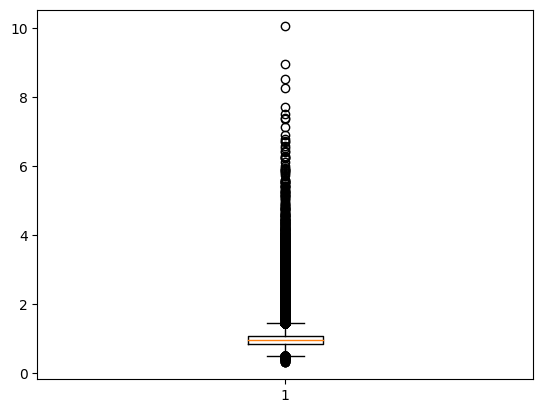




               m_jjj
count  100000.000000
mean        1.023153
std         0.371610
min         0.303144
25%         0.846631
50%         0.950719
75%         1.083218
max        10.038273
feature:  m_lv


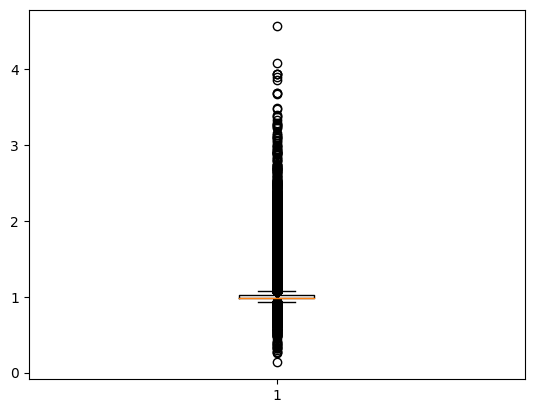




                m_lv
count  100000.000000
mean        1.050193
std         0.164857
min         0.133012
25%         0.985775
50%         0.989742
75%         1.020762
max         4.565248
feature:  m_jlv


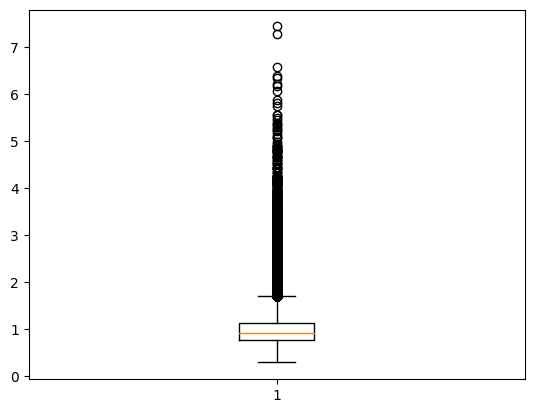




               m_jlv
count  100000.000000
mean        1.010189
std         0.398267
min         0.295983
25%         0.767261
50%         0.917302
75%         1.141633
max         7.442589
feature:  m_bb


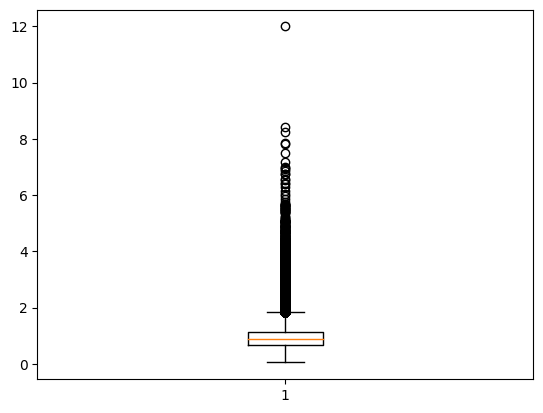




                m_bb
count  100000.000000
mean        0.973081
std         0.523552
min         0.048125
25%         0.673792
50%         0.874004
75%         1.139816
max        11.994177
feature:  m_wbb


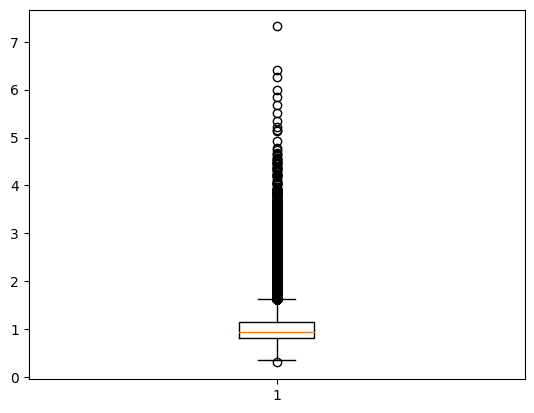




               m_wbb
count  100000.000000
mean        1.031873
std         0.363394
min         0.303350
25%         0.819170
50%         0.947037
75%         1.139032
max         7.318191
feature:  m_wwbb


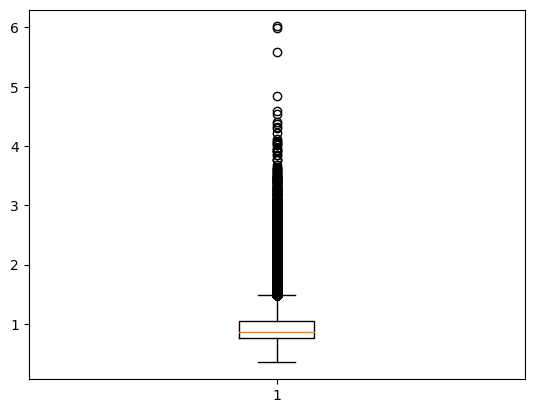




              m_wwbb
count  100000.000000
mean        0.959199
std         0.313257
min         0.350939
25%         0.769964
50%         0.871038
75%         1.057478
max         6.015647
   Getting train-test datasets   
Assembly-normalise
Train-test splitting
Assembly-normalise train
Assembly-normalise test
Train schema: 
root
 |-- features: vector (nullable = true)
 |-- higgs_bosons_indexes: double (nullable = false)

Test schema: 
root
 |-- features: vector (nullable = true)
 |-- higgs_bosons_indexes: double (nullable = false)



In [42]:
train, test = rows_with_NaNs_dropping(df_lim, True)

In [43]:
train.show()

+--------------------+--------------------+
|            features|higgs_bosons_indexes|
+--------------------+--------------------+
|[0.0,0.4869891560...|                 1.0|
|[0.0,0.4873136115...|                 1.0|
|[0.0,0.4873136115...|                 1.0|
|[0.0,0.4876380142...|                 1.0|
|[0.0,0.4876380142...|                 1.0|
|[0.0,0.4876380142...|                 1.0|
|[0.0,0.4882869251...|                 1.0|
|[0.0,0.4882869251...|                 1.0|
|[0.0,0.4882869251...|                 1.0|
|[0.0,0.4886113806...|                 1.0|
|[0.0,0.4886113806...|                 1.0|
|[0.0,0.4886113806...|                 1.0|
|[0.0,0.4889357833...|                 1.0|
|[0.0,0.4889357833...|                 1.0|
|[0.0,0.4892602388...|                 1.0|
|[0.0,0.4892602388...|                 1.0|
|[0.0,0.4892602388...|                 1.0|
|[0.0,0.4899091498...|                 1.0|
|[0.0,0.4902335525...|                 1.0|
|[0.0,0.4902335525...|          

In [44]:
test.show()

+--------------------+--------------------+
|            features|higgs_bosons_indexes|
+--------------------+--------------------+
|[0.0,0.4938461029...|                 1.0|
|[0.0,0.4941748542...|                 1.0|
|[0.0,0.4941748542...|                 1.0|
|[0.0,0.4945036590...|                 1.0|
|[0.0,0.4951612688...|                 1.0|
|[0.0,0.4951612688...|                 1.0|
|[0.0,0.4951612688...|                 1.0|
|[0.0,0.4954900201...|                 1.0|
|[0.0,0.4954900201...|                 1.0|
|[0.0,0.4954900201...|                 1.0|
|[0.0,0.4958188249...|                 1.0|
|[0.0,0.4961476298...|                 1.0|
|[0.0,0.4961476298...|                 1.0|
|[0.0,0.4964764346...|                 1.0|
|[0.0,0.4968051860...|                 1.0|
|[0.0,0.4968051860...|                 1.0|
|[0.0,0.4968051860...|                 1.0|
|[0.0,0.4971339908...|                 1.0|
|[0.0,0.4971339908...|                 1.0|
|[0.0,0.4971339908...|          

##### Training

In [45]:
train_results = training(train, label = "higgs_bosons_indexes")

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: higgs_bosons_indexes)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins f

##### Testing

In [46]:
testing(test, train_results, label = "higgs_bosons_indexes")

   Testing   
{'cls': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2981a6fff37e, depth=1, numNodes=3, numClasses=2, numFeatures=30, 'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double], 'accuracy': 1.0, 'f1': 1.0}
<class 'dict'>
Classifier:  DecisionTreeClassifier_2981a6fff37e


+--------------------+----------+
|higgs_bosons_indexes|prediction|
+--------------------+----------+
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
+--------------------+----------+
only showing top 20 rows

{'cls': RandomForestClassificationModel: uid=RandomForestClassifier_a82195cbcbe5, numTrees=20, numClasses=2, numFeatures=30, 'train_result': DataFrame[higgs_b

#### Non-normalised

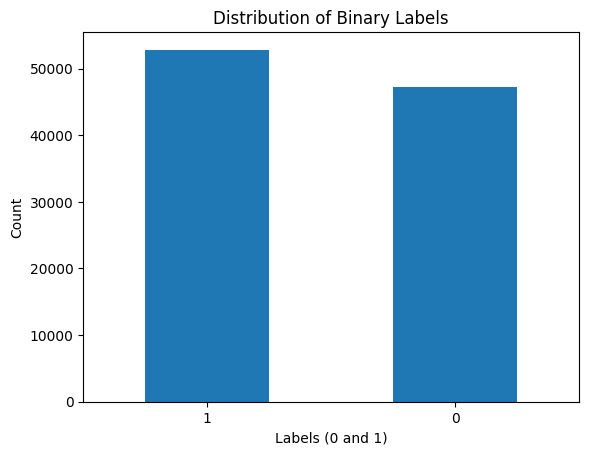

   Rows reduction checking   
Before dropping rows with NaNs: 
number of rows:  100000
After dropping rows with NaNs: 
number of rows:  100000


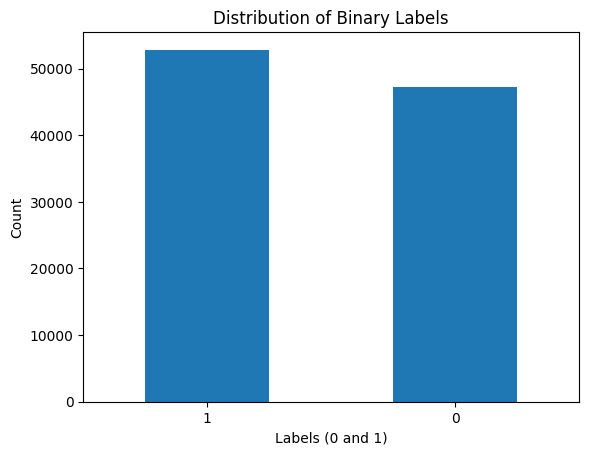

   Data description   
['higgs_bosons', 'lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b-tag', 'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b-tag', 'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b-tag', 'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
feature:  lepton_pT


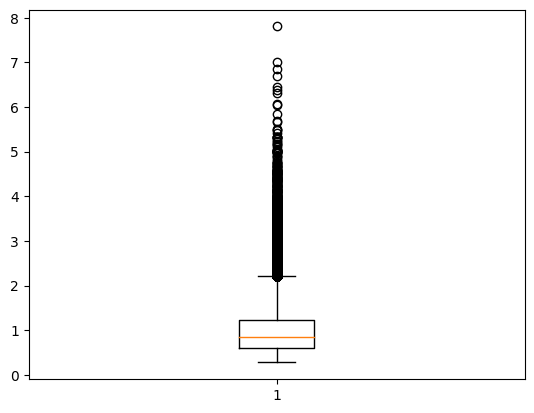




           lepton_pT
count  100000.000000
mean        0.990371
std         0.561837
min         0.274697
25%         0.590936
50%         0.854835
75%         1.236776
max         7.805887
feature:  lepton_eta


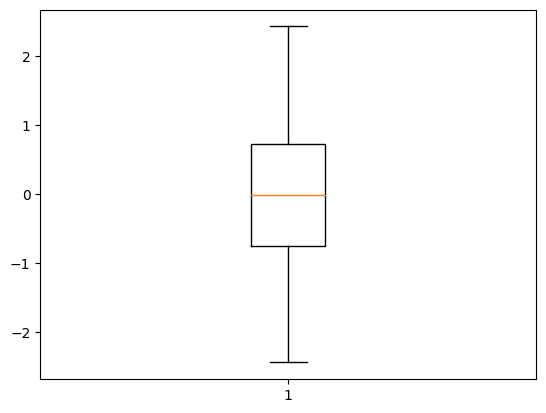




          lepton_eta
count  100000.000000
mean       -0.003816
std         1.004841
min        -2.434976
25%        -0.741244
50%        -0.002976
75%         0.735292
max         2.433894
feature:  lepton_phi


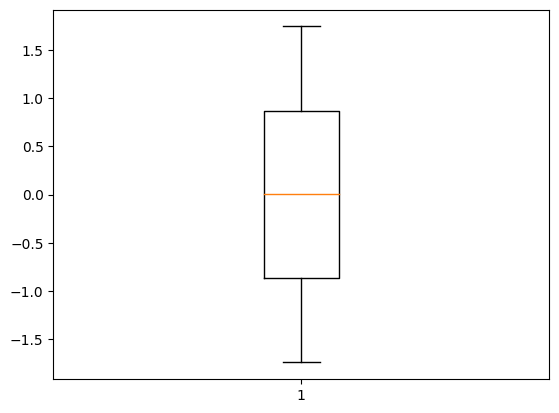




          lepton_phi
count  100000.000000
mean       -0.001638
std         1.006189
min        -1.742508
25%        -0.868047
50%         0.000971
75%         0.868220
max         1.743236
feature:  missing_energy_magnitude


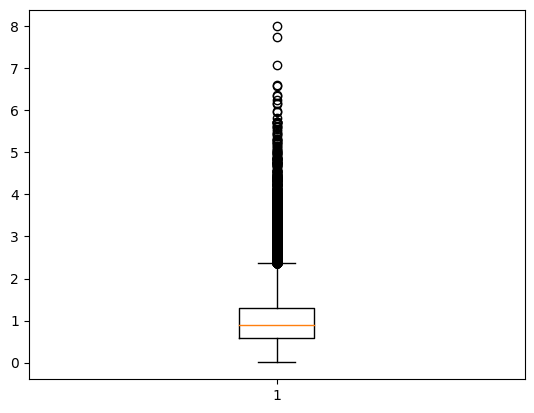




       missing_energy_magnitude
count             100000.000000
mean                   0.995049
std                    0.595360
min                    0.001283
25%                    0.575635
50%                    0.890268
75%                    1.290871
max                    7.998711
feature:  missing_energy_phi


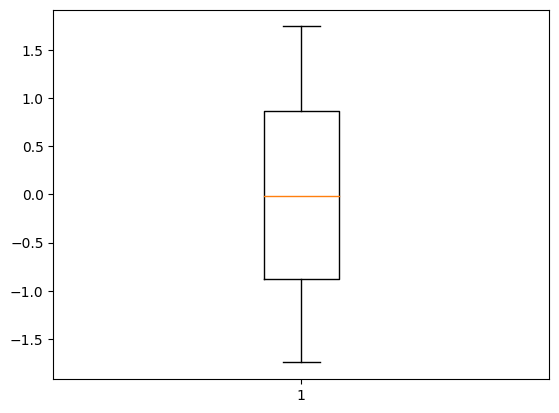




       missing_energy_phi
count       100000.000000
mean            -0.007613
std              1.006997
min             -1.743944
25%             -0.881465
50%             -0.011024
75%              0.865868
max              1.743229
feature:  jet_1_pt


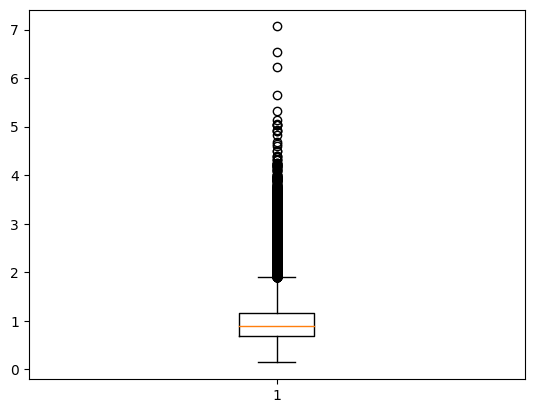




            jet_1_pt
count  100000.000000
mean        0.987114
std         0.473118
min         0.139976
25%         0.676336
50%         0.892163
75%         1.167809
max         7.064657
feature:  jet_1_eta


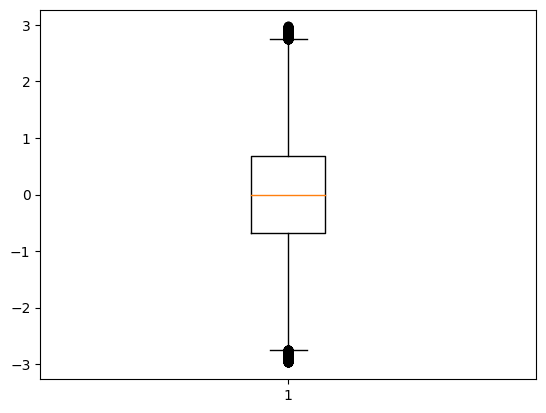




           jet_1_eta
count  100000.000000
mean       -0.003000
std         1.008685
min        -2.968735
25%        -0.688235
50%        -0.000025
75%         0.683233
max         2.969674
feature:  jet_1_phi


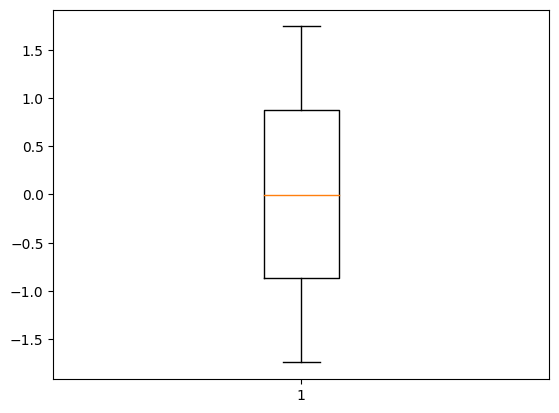




           jet_1_phi
count  100000.000000
mean        0.000438
std         1.008430
min        -1.741237
25%        -0.867542
50%        -0.003822
75%         0.871223
max         1.741454
feature:  jet_1_b-tag


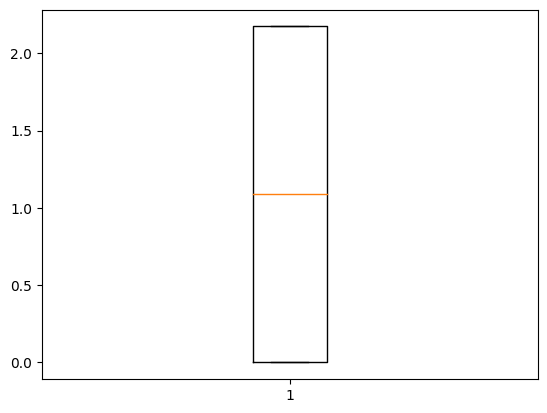




         jet_1_b-tag
count  100000.000000
mean        0.998344
std         1.027402
min         0.000000
25%         0.000000
50%         1.086538
75%         2.173076
max         2.173076
feature:  jet_2_pt


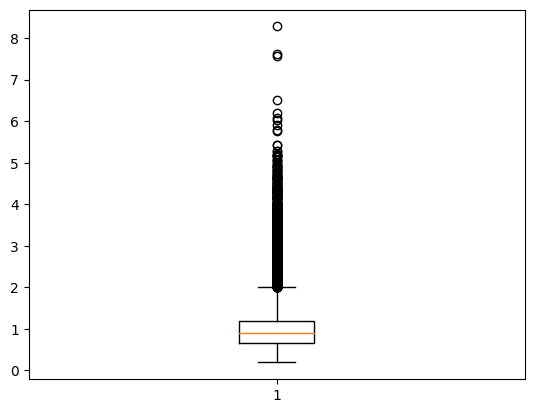




            jet_2_pt
count  100000.000000
mean        0.991302
std         0.498242
min         0.188981
25%         0.656964
50%         0.889256
75%         1.199483
max         8.280169
feature:  jet_2_eta


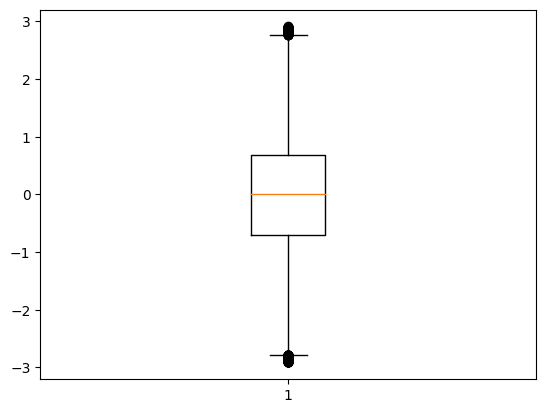




           jet_2_eta
count  100000.000000
mean       -0.001061
std         1.004953
min        -2.913090
25%        -0.695443
50%         0.002003
75%         0.691921
max         2.913210
feature:  jet_2_phi


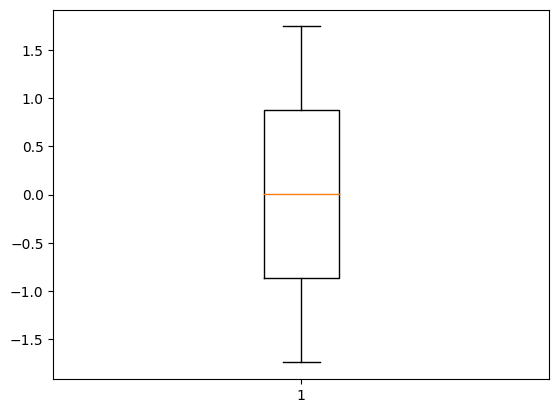




           jet_2_phi
count  100000.000000
mean        0.003546
std         1.006867
min        -1.742372
25%        -0.868515
50%         0.008222
75%         0.876531
max         1.743175
feature:  jet_2_b-tag


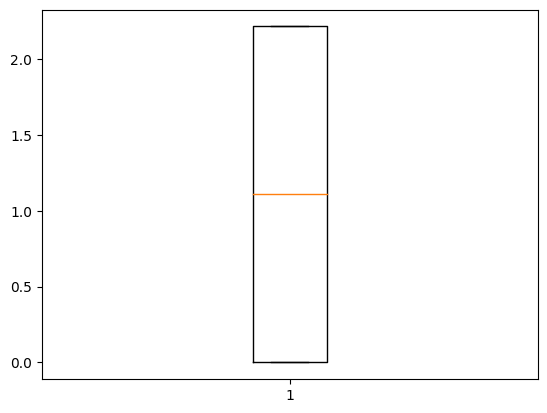




         jet_2_b-tag
count  100000.000000
mean        1.004145
std         1.049192
min         0.000000
25%         0.000000
50%         1.107436
75%         2.214872
max         2.214872
feature:  jet_3_pt


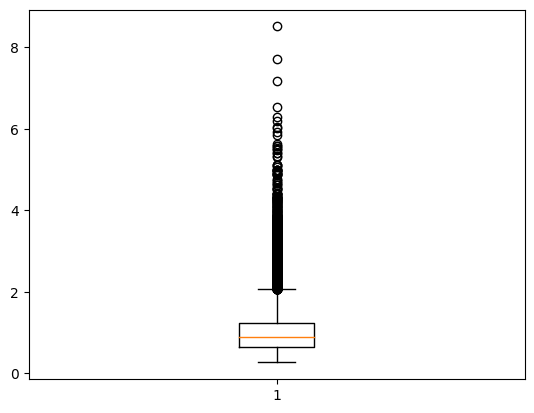




            jet_3_pt
count  100000.000000
mean        0.993414
std         0.487705
min         0.263608
25%         0.654892
50%         0.898479
75%         1.221798
max         8.509908
feature:  jet_3_eta


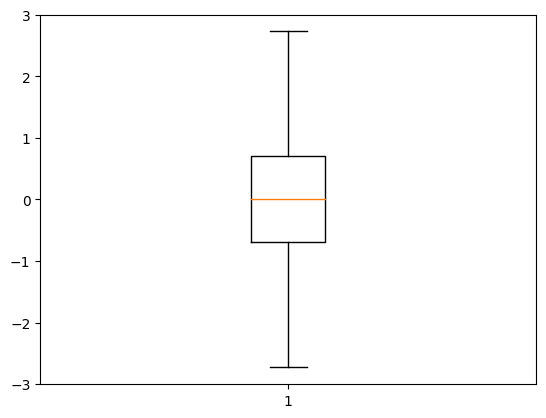




           jet_3_eta
count  100000.000000
mean        0.002149
std         1.008668
min        -2.729663
25%        -0.696167
50%         0.001993
75%         0.701975
max         2.730009
feature:  jet_3_phi


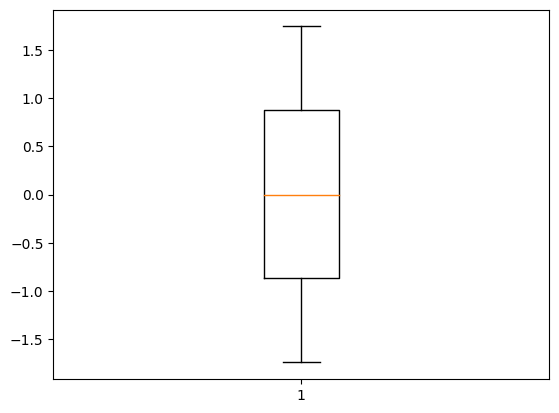




           jet_3_phi
count  100000.000000
mean        0.001222
std         1.005330
min        -1.742069
25%        -0.865587
50%        -0.000752
75%         0.873614
max         1.742884
feature:  jet_3_b-tag


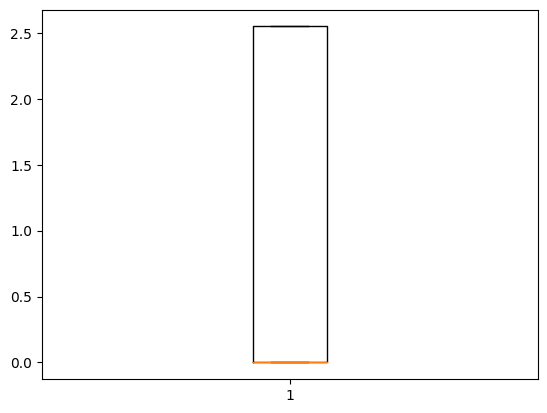




         jet_3_b-tag
count  100000.000000
mean        1.005580
std         1.196112
min         0.000000
25%         0.000000
50%         0.000000
75%         2.548224
max         2.548224
feature:  jet_4_pt


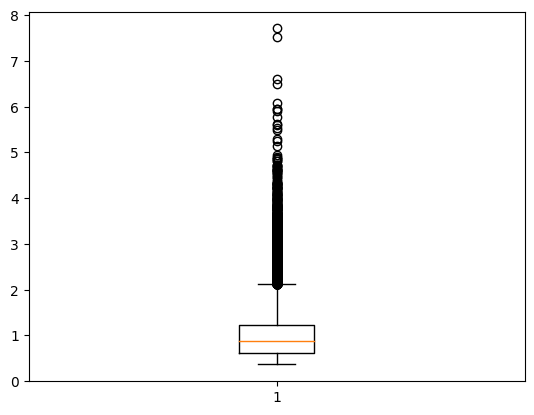




            jet_4_pt
count  100000.000000
mean        0.985523
std         0.504635
min         0.365354
25%         0.617463
50%         0.869207
75%         1.220687
max         7.705783
feature:  jet_4_eta


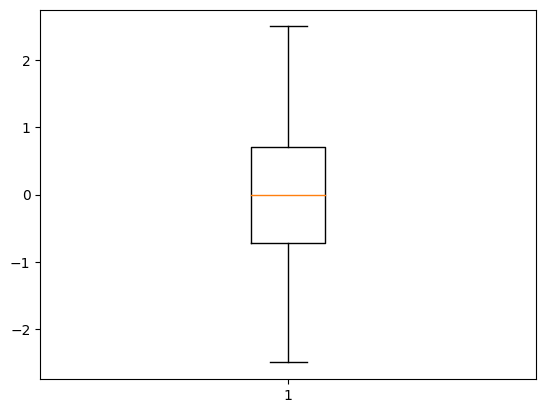




           jet_4_eta
count  100000.000000
mean       -0.007575
std         1.009173
min        -2.497265
25%        -0.725017
50%        -0.010455
75%         0.710770
max         2.498009
feature:  jet_4_phi


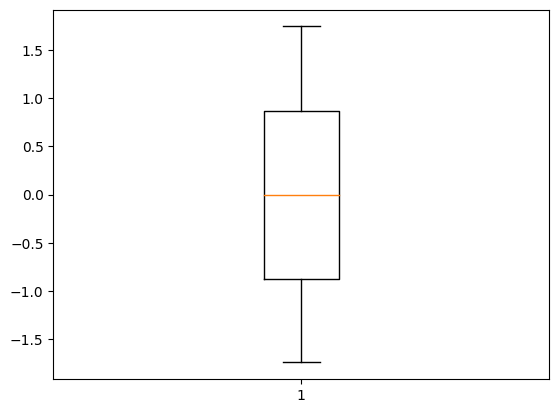




           jet_4_phi
count  100000.000000
mean       -0.004029
std         1.007090
min        -1.742691
25%        -0.877028
50%        -0.009698
75%         0.869386
max         1.743372
feature:  jet_4_b-tag


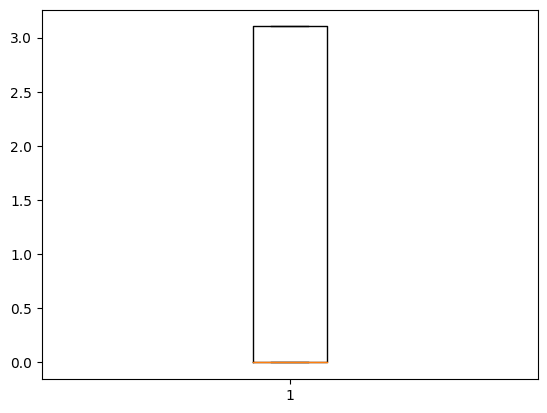




         jet_4_b-tag
count  100000.000000
mean        0.992721
std         1.396788
min         0.000000
25%         0.000000
50%         0.000000
75%         3.101961
max         3.101961
feature:  m_jj


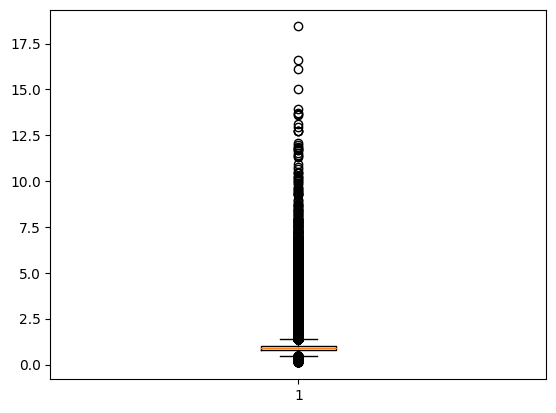




                m_jj
count  100000.000000
mean        1.032611
std         0.652455
min         0.110875
25%         0.791306
50%         0.895600
75%         1.025925
max        18.428827
feature:  m_jjj


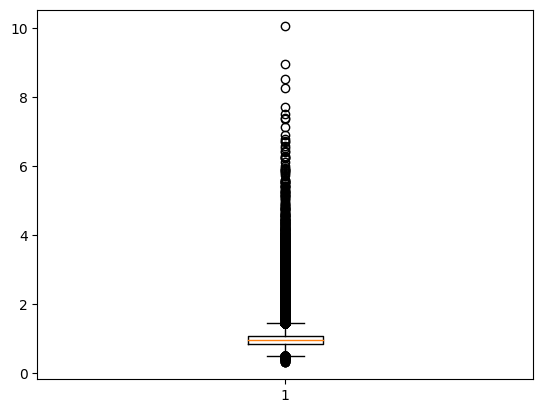




               m_jjj
count  100000.000000
mean        1.023153
std         0.371610
min         0.303144
25%         0.846631
50%         0.950719
75%         1.083218
max        10.038273
feature:  m_lv


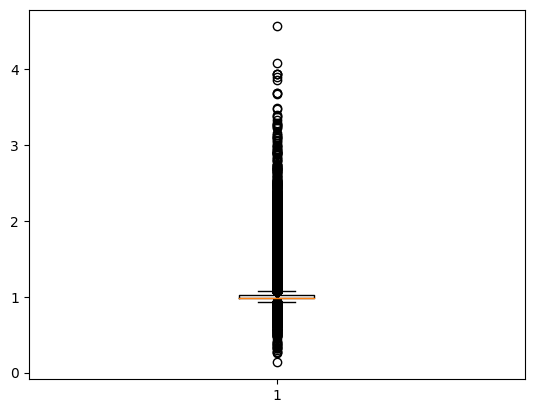




                m_lv
count  100000.000000
mean        1.050193
std         0.164857
min         0.133012
25%         0.985775
50%         0.989742
75%         1.020762
max         4.565248
feature:  m_jlv


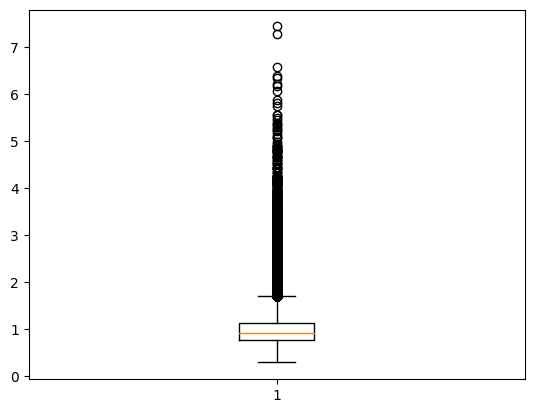




               m_jlv
count  100000.000000
mean        1.010189
std         0.398267
min         0.295983
25%         0.767261
50%         0.917302
75%         1.141633
max         7.442589
feature:  m_bb


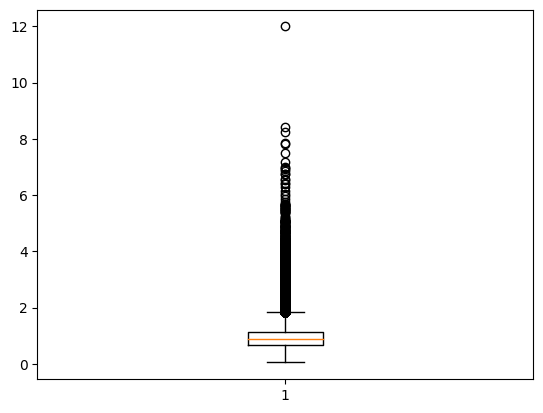




                m_bb
count  100000.000000
mean        0.973081
std         0.523552
min         0.048125
25%         0.673792
50%         0.874004
75%         1.139816
max        11.994177
feature:  m_wbb


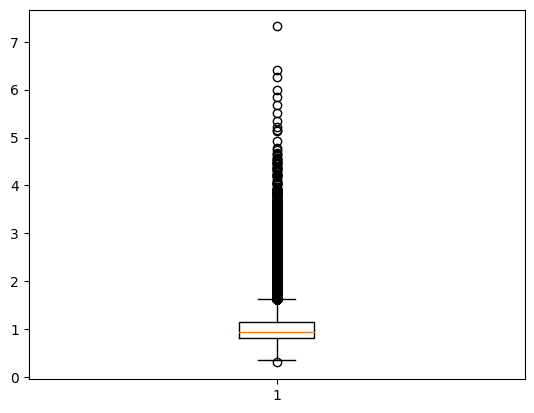




               m_wbb
count  100000.000000
mean        1.031873
std         0.363394
min         0.303350
25%         0.819170
50%         0.947037
75%         1.139032
max         7.318191
feature:  m_wwbb


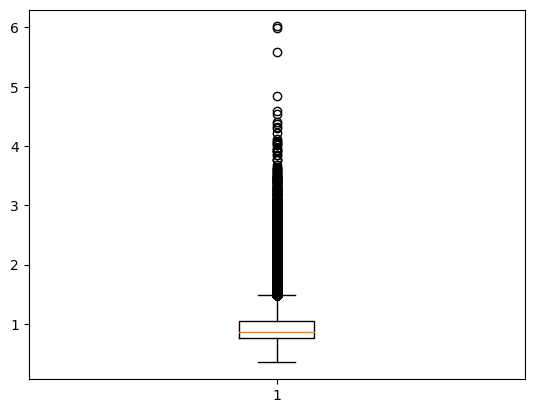




              m_wwbb
count  100000.000000
mean        0.959199
std         0.313257
min         0.350939
25%         0.769964
50%         0.871038
75%         1.057478
max         6.015647
   Getting train-test datasets   
Assembly
Train-test splitting
DataFrame[higgs_bosons: int, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet_1_pt: double, jet_1_eta: double, jet_1_phi: double, jet_1_b-tag: double, jet_2_pt: double, jet_2_eta: double, jet_2_phi: double, jet_2_b-tag: double, jet_3_pt: double, jet_3_eta: double, jet_3_phi: double, jet_3_b-tag: double, jet_4_pt: double, jet_4_eta: double, jet_4_phi: double, jet_4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, higgs_bosons_indexes: double]
DataFrame[higgs_bosons: int, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet

In [47]:
train, test = rows_with_NaNs_dropping(df_lim, False)

In [48]:
train.show()

+--------------------+--------------------+
|            features|higgs_bosons_indexes|
+--------------------+--------------------+
|[0.0,0.2746966481...|                 1.0|
|[0.0,0.2748796641...|                 1.0|
|[0.0,0.2748796641...|                 1.0|
|[0.0,0.2750626504...|                 1.0|
|[0.0,0.2750626504...|                 1.0|
|[0.0,0.2750626504...|                 1.0|
|[0.0,0.2754286825...|                 1.0|
|[0.0,0.2754286825...|                 1.0|
|[0.0,0.2754286825...|                 1.0|
|[0.0,0.2756116986...|                 1.0|
|[0.0,0.2756116986...|                 1.0|
|[0.0,0.2756116986...|                 1.0|
|[0.0,0.2757946848...|                 1.0|
|[0.0,0.2757946848...|                 1.0|
|[0.0,0.2759777009...|                 1.0|
|[0.0,0.2759777009...|                 1.0|
|[0.0,0.2759777009...|                 1.0|
|[0.0,0.2763437330...|                 1.0|
|[0.0,0.2765267193...|                 1.0|
|[0.0,0.2765267193...|          

In [49]:
test.show()

+--------------------+--------------------+
|            features|higgs_bosons_indexes|
+--------------------+--------------------+
|[0.0,0.2748796641...|                 1.0|
|[0.0,0.2750626504...|                 1.0|
|[0.0,0.2750626504...|                 1.0|
|[0.0,0.2752456665...|                 1.0|
|[0.0,0.2756116986...|                 1.0|
|[0.0,0.2756116986...|                 1.0|
|[0.0,0.2756116986...|                 1.0|
|[0.0,0.2757946848...|                 1.0|
|[0.0,0.2757946848...|                 1.0|
|[0.0,0.2757946848...|                 1.0|
|[0.0,0.2759777009...|                 1.0|
|[0.0,0.2761607170...|                 1.0|
|[0.0,0.2761607170...|                 1.0|
|[0.0,0.2763437330...|                 1.0|
|[0.0,0.2765267193...|                 1.0|
|[0.0,0.2765267193...|                 1.0|
|[0.0,0.2765267193...|                 1.0|
|[0.0,0.2767097353...|                 1.0|
|[0.0,0.2767097353...|                 1.0|
|[0.0,0.2767097353...|          

##### Training

In [50]:
train_results = training(train, label = "higgs_bosons_indexes")

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: higgs_bosons_indexes)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins f

##### Testing

In [51]:
testing(test, train_results, label = "higgs_bosons_indexes")

   Testing   
{'cls': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b65c3be40b3d, depth=1, numNodes=3, numClasses=2, numFeatures=30, 'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double], 'accuracy': 1.0, 'f1': 1.0}
<class 'dict'>
Classifier:  DecisionTreeClassifier_b65c3be40b3d
+--------------------+----------+
|higgs_bosons_indexes|prediction|
+--------------------+----------+
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|   

## Feature selection

### Non-normalised

In [52]:
train, test = axisAggregation_featureSelection(df_lim, False, threshold = 0.5, label = "higgs_bosons")

   Feature aggregation and selection   
Dropping NaNs
Feature selection: features with a variance greater than threshold
Train-test creation
Fit-transform
Train-test split
Train schema: 
root
 |-- higgs_bosons: integer (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet_1_eta: double (nullable = true)
 |-- jet_1_phi: double (nullable = true)
 |-- jet_1_b-tag: double (nullable = true)
 |-- jet_2_eta: double (nullable = true)
 |-- jet_2_phi: double (nullable = true)
 |-- jet_2_b-tag: double (nullable = true)
 |-- jet_3_eta: double (nullable = true)
 |-- jet_3_phi: double (nullable = true)
 |-- jet_3_b-tag: double (nullable = true)
 |-- jet_4_pt: double (nullable = true)
 |-- jet_4_eta: double (nullable = true)
 |-- jet_4_phi: double (nullable = true)
 |-- jet_4_b-tag: double (nullable 

#### Training

In [53]:
train_results = training(train, label = "higgs_bosons_indexes")

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: higgs_bosons_indexes)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins f

In [54]:
train_results

{DecisionTreeClassifier_2ec9b420254e: {'cls': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2ec9b420254e, depth=1, numNodes=3, numClasses=2, numFeatures=21,
  'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double],
  'accuracy': 1.0,
  'f1': 1.0},
 RandomForestClassifier_e0865629d862: {'cls': RandomForestClassificationModel: uid=RandomForestClassifier_e0865629d862, numTrees=20, numClasses=2, numFeatures=21,
  'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double],
  'accuracy': 1.0,
  'f1': 1.0},
 KMeans_1874216b565e: {'cls': KMeansModel: uid=KMeans_1874216b565e, k=2, distanceMeasure=euclidean, numFeatures=21,
  'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double],
  'accuracy': 0.5038303810445975,
  'f1': 0.4926267437693037}}

#### Testing

In [55]:
testing(test, train_results, label = "higgs_bosons_indexes")

   Testing   
{'cls': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2ec9b420254e, depth=1, numNodes=3, numClasses=2, numFeatures=21, 'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double], 'accuracy': 1.0, 'f1': 1.0}
<class 'dict'>
Classifier:  DecisionTreeClassifier_2ec9b420254e
+--------------------+----------+
|higgs_bosons_indexes|prediction|
+--------------------+----------+
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|   

### Normalised

In [56]:
train, test = axisAggregation_featureSelection(df_lim, True, threshold = 0.5, label = "higgs_bosons")

   Feature aggregation and selection   
Dropping NaNs
Feature selection: features with a variance greater than threshold
Train-test creation
Fit-transform normalise
Fit-transform
Train-test split
Normalise train
Normalise test
Train schema: 
root
 |-- higgs_bosons: integer (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet_1_eta: double (nullable = true)
 |-- jet_1_phi: double (nullable = true)
 |-- jet_1_b-tag: double (nullable = true)
 |-- jet_2_eta: double (nullable = true)
 |-- jet_2_phi: double (nullable = true)
 |-- jet_2_b-tag: double (nullable = true)
 |-- jet_3_eta: double (nullable = true)
 |-- jet_3_phi: double (nullable = true)
 |-- jet_3_b-tag: double (nullable = true)
 |-- jet_4_pt: double (nullable = true)
 |-- jet_4_eta: double (nullable = true)
 |-- jet_4_phi: doubl

#### Training

In [57]:
train_results = training(train, label = "higgs_bosons_indexes")

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: higgs_bosons_indexes)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins f

#### Testing

In [58]:
testing(test, train_results, label = "higgs_bosons_indexes")

   Testing   
{'cls': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_55cd251d7e54, depth=1, numNodes=3, numClasses=2, numFeatures=21, 'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double], 'accuracy': 1.0, 'f1': 1.0}
<class 'dict'>
Classifier:  DecisionTreeClassifier_55cd251d7e54


+--------------------+----------+
|higgs_bosons_indexes|prediction|
+--------------------+----------+
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
+--------------------+----------+
only showing top 20 rows

{'cls': RandomForestClassificationModel: uid=RandomForestClassifier_4161d506a397, numTrees=20, numClasses=2, numFeatures=21, 'train_result': DataFrame[higgs_b

## Dropping kinematic properties columns

### Non-normalised

In [61]:
df_lim.show(10)

+------------+------------------+-------------------+--------------------+------------------------+--------------------+------------------+--------------------+--------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+--------------------+-------------------+-----------------+-------------------+--------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|higgs_bosons|         lepton_pT|         lepton_eta|          lepton_phi|missing_energy_magnitude|  missing_energy_phi|          jet_1_pt|           jet_1_eta|           jet_1_phi|       jet_1_b-tag|          jet_2_pt|          jet_2_eta|           jet_2_phi|       jet_2_b-tag|          jet_3_pt|           jet_3_eta|          jet_3_phi|      jet_3_b-tag|           jet_4_pt|           jet_4_eta|           jet_4_phi|      jet

In [69]:
train, test = dropping_columns_from_df(df_lim, False, columns_to_drop = kinematic_properties_columns)

   Dropping kineamtic properites columns   
Dropping heart_rate column
Assembly
Train-test splitting
DataFrame[higgs_bosons: int, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, higgs_bosons_indexes: double]
DataFrame[higgs_bosons: int, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, higgs_bosons_indexes: double]
Assembly train
Assembly test
Train schema: 
root
 |-- features: vector (nullable = true)
 |-- higgs_bosons_indexes: double (nullable = false)

Test schema: 
root
 |-- features: vector (nullable = true)
 |-- higgs_bosons_indexes: double (nullable = false)



#### Training

In [70]:
train_results = training(train, label = "higgs_bosons_indexes")

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: higgs_bosons_indexes)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins f

#### Testing

In [71]:
testing(test, train_results, label = "higgs_bosons_indexes")

   Testing   
{'cls': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_389ab6d3927b, depth=1, numNodes=3, numClasses=2, numFeatures=9, 'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double], 'accuracy': 1.0, 'f1': 1.0}
<class 'dict'>
Classifier:  DecisionTreeClassifier_389ab6d3927b


+--------------------+----------+
|higgs_bosons_indexes|prediction|
+--------------------+----------+
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
+--------------------+----------+
only showing top 20 rows

{'cls': RandomForestClassificationModel: uid=RandomForestClassifier_128494c57554, numTrees=20, numClasses=2, numFeatures=9, 'train_result': DataFrame[higgs_bo

### Normalised

In [72]:
train, test = dropping_columns_from_df(df_lim, True, columns_to_drop = kinematic_properties_columns)

   Dropping kineamtic properites columns   
Dropping heart_rate column


Fit-transform normalise
Fit-transform
Train-test split
Normalise train
Normalise test
Train schema: 
root
 |-- higgs_bosons: integer (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: double (nullable = true)
 |-- m_jlv: double (nullable = true)
 |-- m_bb: double (nullable = true)
 |-- m_wbb: double (nullable = true)
 |-- m_wwbb: double (nullable = true)
 |-- higgs_bosons_indexes: double (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)

Test schema: 
root
 |-- higgs_bosons: integer (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: double (nullable = true)
 |-- m_jlv: double (nullable = true)
 |-- m_bb: double (nullable = true)
 |-- m_wbb: double (nullable = true)
 |-- m_wwbb: double (nullable = true)
 |-- higgs_bosons_indexes: double (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



#### Training

In [73]:
train_results = training(train, label = "higgs_bosons_indexes")

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: higgs_bosons_indexes)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins f

#### Testing

In [74]:
testing(test, train_results, label = "higgs_bosons_indexes")

   Testing   
{'cls': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_966e04503f88, depth=1, numNodes=3, numClasses=2, numFeatures=8, 'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double], 'accuracy': 1.0, 'f1': 1.0}
<class 'dict'>
Classifier:  DecisionTreeClassifier_966e04503f88


+--------------------+----------+
|higgs_bosons_indexes|prediction|
+--------------------+----------+
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
+--------------------+----------+
only showing top 20 rows

{'cls': RandomForestClassificationModel: uid=RandomForestClassifier_13cca2b1155d, numTrees=20, numClasses=2, numFeatures=8, 'train_result': DataFrame[higgs_bo

## Dropping functions columns

### Non-normalised

In [75]:
train, test = dropping_columns_from_df(df_lim, False, columns_to_drop = functions_columns)

   Dropping kineamtic properites columns   
Dropping heart_rate column
Assembly
Train-test splitting
DataFrame[higgs_bosons: int, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet_1_pt: double, jet_1_eta: double, jet_1_phi: double, jet_1_b-tag: double, jet_2_pt: double, jet_2_eta: double, jet_2_phi: double, jet_2_b-tag: double, jet_3_pt: double, jet_3_eta: double, jet_3_phi: double, jet_3_b-tag: double, jet_4_pt: double, jet_4_eta: double, jet_4_phi: double, jet_4_b-tag: double, higgs_bosons_indexes: double]
DataFrame[higgs_bosons: int, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet_1_pt: double, jet_1_eta: double, jet_1_phi: double, jet_1_b-tag: double, jet_2_pt: double, jet_2_eta: double, jet_2_phi: double, jet_2_b-tag: double, jet_3_pt: double, jet_3_eta: double, jet_3_phi: double, jet_3_b-tag: double, jet_4_pt: double, jet_4_eta: d

#### Training

In [76]:
train_results = training(train, label = "higgs_bosons_indexes")

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: higgs_bosons_indexes)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins f

#### Testing

In [77]:
testing(test, train_results, label = "higgs_bosons_indexes")

   Testing   
{'cls': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ef6a70b15f97, depth=1, numNodes=3, numClasses=2, numFeatures=23, 'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double], 'accuracy': 1.0, 'f1': 1.0}
<class 'dict'>
Classifier:  DecisionTreeClassifier_ef6a70b15f97
+--------------------+----------+
|higgs_bosons_indexes|prediction|
+--------------------+----------+
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|   

### Normalised

In [78]:
train, test = dropping_columns_from_df(df_lim, True, columns_to_drop = functions_columns)

   Dropping kineamtic properites columns   
Dropping heart_rate column
Fit-transform normalise
Fit-transform
Train-test split
Normalise train
Normalise test
Train schema: 
root
 |-- higgs_bosons: integer (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet_1_pt: double (nullable = true)
 |-- jet_1_eta: double (nullable = true)
 |-- jet_1_phi: double (nullable = true)
 |-- jet_1_b-tag: double (nullable = true)
 |-- jet_2_pt: double (nullable = true)
 |-- jet_2_eta: double (nullable = true)
 |-- jet_2_phi: double (nullable = true)
 |-- jet_2_b-tag: double (nullable = true)
 |-- jet_3_pt: double (nullable = true)
 |-- jet_3_eta: double (nullable = true)
 |-- jet_3_phi: double (nullable = true)
 |-- jet_3_b-tag: double (nullable = true)
 |-- jet_4_pt: double (nullable = true)
 |-- jet_4_e

#### Training

In [79]:
train_results = training(train, label = "higgs_bosons_indexes")

   Training   
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: higgs_bosons_indexes)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins f

#### Testing

In [80]:
testing(test, train_results, label = "higgs_bosons_indexes")

   Testing   
{'cls': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_4e94c0c6e5df, depth=1, numNodes=3, numClasses=2, numFeatures=22, 'train_result': DataFrame[higgs_bosons_indexes: double, prediction: double], 'accuracy': 1.0, 'f1': 1.0}
<class 'dict'>
Classifier:  DecisionTreeClassifier_4e94c0c6e5df
+--------------------+----------+
|higgs_bosons_indexes|prediction|
+--------------------+----------+
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|                 1.0|       1.0|
|   